# Lab 02 - Decision Tree - I

We are using the Titanic dataset for this lab. Please download the lab02_dataset.zip from the moodle and extract it in the 
same directory as this notebook. The dataset has the passenger details of Titanic and whether they survived the disaster or not.

We will do a few things in this lab. First, we will try to define a general structure for a good notebook. Then we will follow that structure and implement a simple decision tree model using categorical features.

## General structure of a notebook

Notebooks are all about telling a story, so like every good story out there notebooks should have a good structure to 
its content. Below is a structure most of the notebooks follow,

1. Import libraries.
2. Acquire training and testing data.
3. Prepare, cleanse the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict and evaluate.
6. Visualize, report, and present the problem solving steps and final solution.

**Note:** This is not the one and only structure you should follow. Take this as an example of a good structure. You 
have the freedom to be creative. As an example, you can visualize data to analyze them, you can analyze data before 
and after cleaning, etc. After all, storytelling is not an exact science.

### Importing libraries

We need libraries for data cleaning, analyzing, training machine learning models, visualizing and evaluating.

In [1]:
# data analysis and preparing
import pandas as pd
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics

## Acquire data

We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run 
certain operations on both datasets together.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

## Prepare and clean data

First let's see what are the features we have.

In [3]:
print(train_df.columns.values.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


Let's get a preview of the data.

In [4]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Next, we have to identify the types of our features. This information will be useful when we prepare our data for ML 
algorithms and visualizing the data.

There are two basic feature types,

1. Categorical features - contain a finite number of categories or distinct groups.
2. Continuous features - numeric variables that have an infinite number of values between any two values.

If your data type is discrete (has a countable number of values between any two values), you can treat them either 
as a continuous or as a categorical feature.

So in our dataset these are the feature types we can identify,

* Categorical - Survived, Sex, Embarked, Ticket, cabin and Pclass.
* Continuous - Age, Fare. 
* Discrete - SibSp, Parch.

### Identifying missing values

Let us first identify which features have missing values.
 

In [5]:
train_df.info()
print('#'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

You can see that in training set, Age, Cabin and Embarked features have missing values. Age, Fare and Cabin features 
have missing values in test set.

You can see at the first glance that the Cabin feature has missing values more than 70% in both train and test sets. 
This can negatively impact our prediction model. So we can eliminate this feature from the datasets.

In [6]:
for df in combine:
    df.drop('Cabin', axis=1, inplace=True)
    

## Data analysis

Let's take a look at the data summary of training set.

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


from this information we can outline the following points about the dataset.

- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived
- Most passengers (> 75%) did not travel with parents or children.

In [8]:
train_df.describe(percentiles=[.1, .2, .6, .7, .8, .9, .95, .99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
10%,90.000000,0.000000,1.000000,14.000000,0.000000,0.000000,7.550000
20%,179.000000,0.000000,1.000000,19.000000,0.000000,0.000000,7.854200
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,535.000000,0.000000,3.000000,31.800000,0.000000,0.000000,21.679200
70%,624.000000,1.000000,3.000000,36.000000,1.000000,0.000000,27.000000
80%,713.000000,1.000000,3.000000,41.000000,1.000000,1.000000,39.687500


- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<2%) within age range 65-80 years.

In [9]:
# Only categorical features
train_df.describe(include=['O'])

,Name,Sex,Ticket,Embarked
count,891,891,891,889
unique,891,2,681,3
top,"Allison, Master. Hudson Trevor",male,1601,S
freq,1,577,7,644


- Names are unique across the dataset. (count=unique=891)
- Sex variable has two possible values with 65% male. (top=male, freq=577/count=891)
- Embarked takes three possible values. S port used by most passengers
- Ticket feature has high ratio (22%) of duplicate values.

#### Correlation

We need to understand how well each feature correlates with 'Survival' to get an idea about which features we should 
or should not use in our prediction models. In classification tasks, if feature has good correlation with the target, 
that feature has a high chance to be a good feature. 

Since we are using categorical features today, we can analyze our feature correlations by pivoting them against each 
other. But we can do it only for features with no missing values.

In [10]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [13]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


You can see that Pclass and Sex do have good correlation with Survived but SibSp and Parch do not.

### Visualizing data

Let's try to visualize these correlations. We can use matplotlib and seaborn libraries to create plots. You can find 
the official documentations here: 

matplotlib : https://matplotlib.org/3.3.1/contents.html

Seaborn: https://seaborn.pydata.org/tutorial.html

First let's see how to plot a simple line plot. Let's plot SibSp with Survived using seaborn.

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

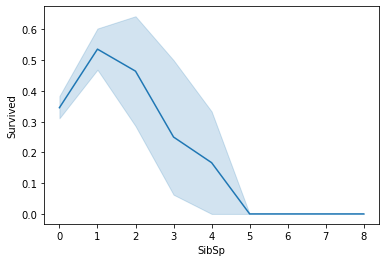

In [14]:
sns.lineplot(x='SibSp', y='Survived', data=train_df)

The blue line shows the estimations of Survived, and light blue area around it depicts the confidence interval.

We can use FacetGrid api in seaborn to create a multiplot grid. For an example let us create a multiplot grid to plot 
Pclass and Survived with Sex.

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


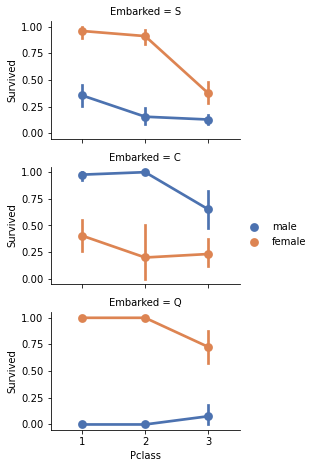

In [15]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Observations we can have from this plot.

- Female passengers had much better survival rate than males.
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked 
and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers.
- SibSp feature might not be that useful for predictions.

Let's analyze Age feature now. Let's plot histograms of age against 'Survived'.

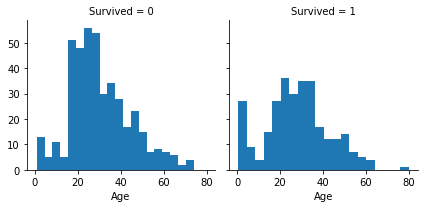

In [16]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Observations.

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

So we can safely say that Age is a really good feature.

## Back to cleaning

Based on our simple data analysis we can safely say that age and Embarked can be useful features. So we cannot drop those 
features. Also Ticket feature has high ratio of duplicates, and it might not have a correlation to survival. So it can 
affect the training accuracy negatively. PassengerId should also be dropped.

We can replace missing values of 'Embarked' feature with the mode.

In [17]:
# dropping 'Ticket' and 'PassengerID' and completing 'Embarked' by replacing NaN with the mode.
for df in combine:
    df.drop(columns=['Ticket', 'PassengerId'], inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode(dropna=True)[0], inplace=True)
    
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


## Data Preparation

Data preparation is one of the key steps in the ML process. Some of the algorithms does not understand some of the data 
as it is, or not compatible with some types of data. As an example, Decision tree classifier we are using does not 
work with string labels. So we have to use an encoding method to transform categorical information to numerical 
information.

For now let us use the very basic encoding method, numeric encoding. Numerical Encoding is very simple: assign an 
arbitrary number to each category. We can use replace method for this. First we have to create a map.

In [18]:
num_encode = {
    'Sex': {'male': 0, "female": 1},
    'Embarked': {'S': 0, 'Q': 1, 'C': 2 }
}

Then we can use replace method in pandas dataframe to replace labels with numerical ones.

In [19]:
for df in combine:
    df.replace(num_encode, inplace=True)

Before modelling our dataset, we have to divide our train set to training and validation sets. This will help us 
evaluate the data more accurately in the training process. After we decided on a final model, we use the test 
dataset to measure the performance of our model. This method will help us reduce overfitting.

You can learn more on evaluation methods next week. 

First we have to move all the features to one dataframe and the target to a series, but preserving the index. Because 
this is the first part of the lab, let's only take tha categorical features. We can consider SibSp and Parch as 
categorical here.

In [20]:
X = train_df[['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']]
y = train_df['Survived']

Now the X variable is the attribute set and y variable contains corresponding labels.

The model_selection library of Scikit-Learn contains train_test_split method. We can use it to randomly split the data 
into training and validating sets.

The test_size parameter specifies the ratio of the test set (Validating set here).

We to split up 30% of the data in to the validating set and 70% for training.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Model and Predict

Now we can train the decision tree algorithm on this data and make predictions. Scikit-Learn contains the tree library, 
which contains built-in classes/methods for various decision tree algorithms.
 
Since we are going to perform a classification task here, we will use the DecisionTreeClassifier class for this example. 

In [22]:
tree = DecisionTreeClassifier(criterion='entropy')

We are going to use entropy as the splitting criteria as you learned in the class. There are a lot of other parameters 
you can change and experiment. Please find them here.

 https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

The fit method of this class is called to train the algorithm on the training data.
Our training data will be passed as parameters to the fit method.

In [23]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Now we can make predictions on the test data. To make predictions, the predict method of the DecisionTreeClassifier 
class is used.

In [24]:
y_pred = tree.predict(x_test)

We can check model accuracy now. Model Accuracy denotes how often the classifier is correct.

In [25]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8208955223880597


## Task

For this week you have to manipulate the dataset given and create a notebook like this.

Please download the 'task_dataset.zip' file from the moodle. It contains two files, bands.data and bands.names.
- First read the bands.names. It has an introduction to bands dataset and useful information on the attributes and missing 
values.  
- Open the bands.data and understand the filetype. Try to figure out what are the symbols used to encode missing values.

Make sure your notebook has following things covered.
- Cleaning
- Analyzing
- Visualizing
- Preparing
- Modelling and predicting

Your notebook should have a good structure and everything should be presented nicely.